### Welcome to the MediaPipe Model Maker custom model maker 🦄

> In this tutorial, we will be leveraging MediaPipe Model Maker for customizing a Gesture Recognizer Model for recognizing some common hand gestures using a custom crafted dataset.

<br/>

Follow the following steps in order to proceed.

### Install the MediaPipe **Model Maker** package ⚙️⛏️

In [ ]:
!pip install --upgrade pip
!pip install mediapipe-model-maker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import the required libraries ⬇️

In [ ]:
from google.colab import files
import os
import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import gesture_recognizer

import matplotlib.pyplot as plt

#### Clear previously exported model directory (TESTING PURPOSES) ⛔

In [ ]:
# TESTING PURPOSES ONLY!

# import shutil

# Remove all files and subdirectories within "exported_model" directory
# shutil.rmtree('exported_model')

# Create an empty "exported_model" directory
# os.mkdir('exported_model')

## Get the dataset 📦

The dataset for gesture recognition in model maker requires the following format: <br/>
`<dataset_path>/<label_name>/<img_name>.*`.
In addition, one of the label names (`label_names`) must be `none`. <br/><br/>
The `none` label represents any gesture that isn't classified as one of the other gestures.

In [ ]:
# Link Google Drive with Colab (provide necessery permissions) / Optional ⚠️

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Pull dataset from CDN URL
# !wget <CDN → fileName.zip URL>
# !unzip fileName.zip


# Pull (custom) dataset from Google Drive Folder
!unzip gdrive/My\ Drive/gsoc_custom_data/alpha_data_sample.zip
dataset_path = "alpha_data_sample"

Archive:  gdrive/My Drive/gsoc_custom_data/alpha_data_sample.zip
   creating: alpha_data_sample/
   creating: alpha_data_sample/click/
  inflating: alpha_data_sample/click/108.jpg  
  inflating: alpha_data_sample/click/117.jpg  
  inflating: alpha_data_sample/click/118.jpg  
  inflating: alpha_data_sample/click/119.jpg  
  inflating: alpha_data_sample/click/120.jpg  
  inflating: alpha_data_sample/click/121.jpg  
  inflating: alpha_data_sample/click/122.jpg  
  inflating: alpha_data_sample/click/123.jpg  
  inflating: alpha_data_sample/click/124.jpg  
  inflating: alpha_data_sample/click/125.jpg  
  inflating: alpha_data_sample/click/169.jpg  
  inflating: alpha_data_sample/click/170.jpg  
  inflating: alpha_data_sample/click/171.jpg  
  inflating: alpha_data_sample/click/172.jpg  
  inflating: alpha_data_sample/click/173.jpg  
  inflating: alpha_data_sample/click/174.jpg  
  inflating: alpha_data_sample/click/175.jpg  
  inflating: alpha_data_sample/click/176.jpg  
  inflating: alpha_

#### Verify the (custom) dataset by printing the labels. There should be 8 gesture labels, with one of them being the `none` gesture.

In [ ]:
print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
print(labels)

alpha_data_sample
['ok', 'pointUp', 'hovering', 'erase', 'click', 'confirm', 'grab', 'none']


### To better understand the dataset, plot a couple of example images for *each* gesture 🖼️

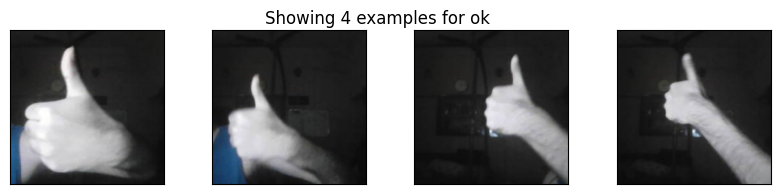

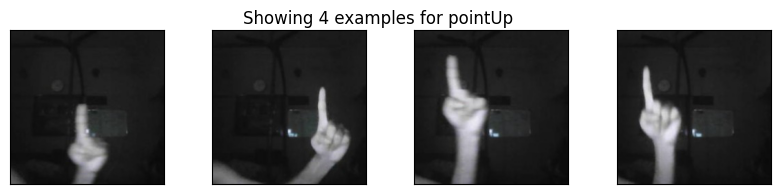

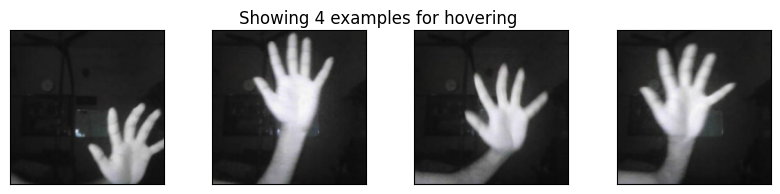

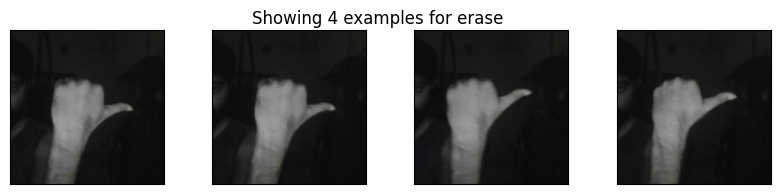

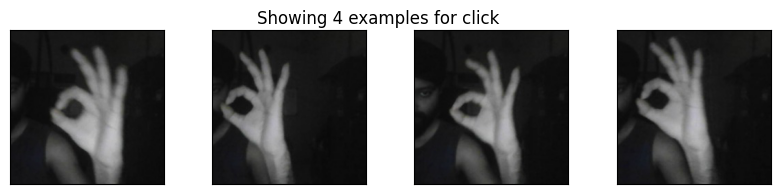

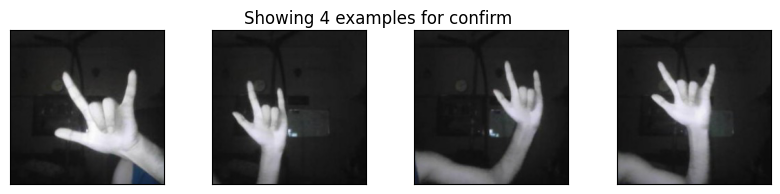

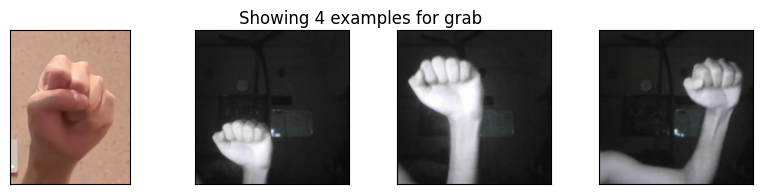

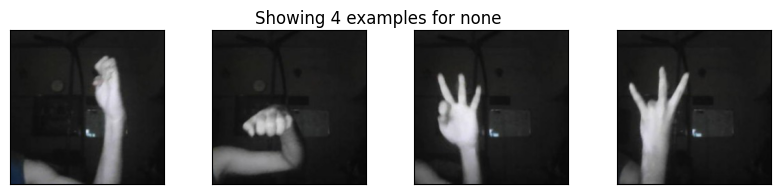

In [ ]:
NUM_EXAMPLES = 4  # Customizable per need

for label in labels:
  label_dir = os.path.join(dataset_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

## Run the example 🚴
The workflow consists of 4 steps which have been separated into their own code blocks.

<br/>

#### **Load the dataset**

Load the dataset located at `dataset_path` by using the `Dataset.from_folder` method. When loading the dataset, run the pre-packaged hand detection model from MediaPipe Hands to detect the hand landmarks from the images. Any images without detected hands are ommitted from the dataset. The resulting dataset will contain the extracted hand landmark positions from each image, rather than images themselves.

<br/>

The `HandDataPreprocessingParams` class contains two configurable options for the data loading process:

- **`shuffle`**: A boolean controlling whether to shuffle the dataset. Defaults to true.
- **`min_detection_confidence`**: A float between 0 and 1 controlling the confidence threshold for hand detection.

<br/>

Split the dataset: 80% for training, 10% for validation, and 10% for testing.

In [ ]:
data = gesture_recognizer.Dataset.from_folder(
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

## Train the model 🏋️

Train the custom gesture recognizer by using the create method and passing in the training data, validation data, model options, and hyperparameters. For more information on model options and hyperparameters, see the Hyperparameters section below.

In [ ]:
hparams = gesture_recognizer.HParams(export_dir="exported_model")
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer)  [(None, 128)]            0         
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 128)               0         
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 custom_gesture_recognizer_o  (None, 8)                1032      
 ut (Dense)                                                      
                                                                 
Total params: 1,544
Trainable params: 1,288
Non-trainable p

## Evaluate the model performance 🔬
> After training the model, evaluate it on a test dataset and print the loss and accuracy metrics.


In [ ]:
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")

192/192 [==============================] - 3s 3ms/step - loss: 0.2387 - categorical_accuracy: 0.8281
Test loss:0.2386528104543686, Test accuracy:0.828125


In [ ]:
# Export the model
model.export_model()

Using existing files at /tmp/model_maker/gesture_recognizer/gesture_embedder.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/canned_gesture_classifier.tflite


### Download the file 💾⬇

In [ ]:
!ls exported_model
files.download('exported_model/gesture_recognizer.task')